In [8]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

In [9]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self, month_new):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=month_new]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self , month_new):
        df, result_matrix = self.create_result_matrix(month_new)
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        df.drop('month_new_dealer', axis = 1 , inplace = True)
        result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix

In [11]:
instance = DB_Data(host, database, user, password, sql_query)
pivot, result_matrix = instance.state_matrix(28)

In [273]:
instance = DB_Data(host, database, user, password, sql_query)
pivot_aug, result_matrix_aug = instance.state_matrix(14)

In [277]:
result_aug = result_matrix_aug[result_matrix_aug['2023-08']=='Active']
pivot_aug = pivot_aug[pivot_aug.index.isin(result_aug.index)]

In [12]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
7041810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.65
7041815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00


In [320]:
pivot_3 = pivot_3[pivot_3['month_new_dealer']<=14]
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23","06'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_aug = result_matrix_3[result_matrix_3['2023-08']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_aug = pivot_3[pivot_3.index.isin(result_aug.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_aug = pivot_aug[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_aug_1 = result_aug[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_aug.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_aug_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_aug = instance_2.data(pivot_aug, result_aug_1)
val_df_aug = instance_2.discount_pd(val_df_aug , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_aug = instance_2.district(val_df_aug , distt_df , region_df)

In [321]:
val_df_aug

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,m-3_qoq,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region
7000053,0.0,49.00,114.0,-144.0,-107.00,-114.0,-188.0,-156.00,-78.0,-80.00,...,-190.0,155.125000,1.0,0.0,0.0,0.0,44642.060000,6875.000000,27,1
7000086,0.0,60.00,6.0,0.0,60.00,-6.0,-100.0,49.00,-64.0,-27.50,...,-106.0,42.770833,1.0,0.0,0.0,1.0,9929.473333,5136.710000,75,1
7000435,0.0,5.00,168.0,-96.0,-80.00,37.0,-195.0,-43.00,15.0,-175.00,...,-95.0,118.958333,1.0,0.0,0.0,0.0,51094.530000,7666.653333,27,1
7000436,0.0,5.00,10.0,-10.0,-15.00,0.0,-10.0,-16.00,-15.0,-10.00,...,-10.0,16.083333,1.0,0.0,0.0,0.0,2772.470000,1015.620000,2,1
7000463,0.0,31.00,25.0,-13.0,31.00,25.0,-25.0,1.00,0.0,-25.00,...,25.0,13.968750,2.0,0.0,0.0,0.0,6423.066667,2929.680000,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036644,0.0,69.60,27.9,-19.0,44.60,2.9,-32.5,32.10,-47.1,-78.90,...,-8.2,21.608333,1.0,0.0,0.0,0.0,13200.750000,7478.850000,100,1
7036659,0.0,3.50,8.8,-7.0,-11.00,1.8,-5.0,0.25,8.8,-23.25,...,6.3,3.116667,2.0,1.0,1.0,1.0,9932.230000,7531.270000,86,3
7036668,0.0,36.30,55.0,-25.0,11.30,30.0,-25.0,11.30,30.0,-30.00,...,5.0,18.595833,1.0,0.0,0.0,0.0,15308.293333,5664.050000,25,1
7036690,0.0,4.25,4.0,-12.0,-7.75,-8.0,-12.0,-7.75,-44.0,-2.50,...,-8.0,8.947917,2.0,0.0,0.0,0.0,NaN,NaN,112,4


In [322]:
val_df_aug['2023-09'] = 1

In [323]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23","06'23","07'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix_3[result_matrix_3['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot_3[pivot_3.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [324]:
val_df = val_df.merge(result_matrix_3['2023-09'], left_index = True , right_index = True , how = 'left')

In [325]:
val_df_aug_sep = pd.concat([val_df, val_df_aug], axis =0)

In [327]:
val_df_aug_sep['2023-09'] = val_df_aug_sep['2023-09'].replace({'Active':0 , 'Active_1N':1})

In [328]:
val_df_aug_sep = val_df_aug_sep.fillna(0)
import joblib
# Load the model
X = val_df_aug_sep.drop('2023-09' , axis =1)
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_1 = sc.fit_transform(X)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_1)
pred_proba = loaded_model.predict_proba(val_df_1)[:,1]
val_df_aug_sep['predicted'] = predictions
val_df_aug_sep['predict_proba'] = pred_proba

In [330]:
print(confusion_matrix(val_df_aug_sep['2023-09'],val_df_aug_sep['predicted']))
print(classification_report(val_df_aug_sep['2023-09'],val_df_aug_sep['predicted']))

[[4848 1570]
 [ 228  761]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.84      6418
           1       0.33      0.77      0.46       989

    accuracy                           0.76      7407
   macro avg       0.64      0.76      0.65      7407
weighted avg       0.87      0.76      0.79      7407



In [366]:
val_df_aug_sep

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,2023-09,predicted,predict_proba
7000004,80.0,80.00,96.0,60.0,58.00,61.0,-10.0,5.00,-26.5,-31.00,...,0.0,0.0,0.0,30874.620000,9972.625000,25,1,0,0,0.016393
7000010,13.0,24.00,12.0,1.0,-9.80,12.0,13.0,24.00,12.0,-11.00,...,1.0,1.0,5.0,3024.923047,937.490000,51,1,0,1,0.622951
7000022,24.0,12.00,12.0,12.0,0.00,9.0,24.0,-12.00,-9.0,-3.00,...,0.0,0.0,0.0,3236.875781,2083.333333,149,1,1,1,0.606557
7000025,121.0,147.00,109.0,46.0,-28.00,-52.0,-16.0,-20.00,36.0,-11.00,...,0.0,0.0,0.0,60212.108125,19921.866667,237,1,0,0,0.000000
7000029,90.0,90.00,55.0,30.0,60.00,-79.9,2.0,30.00,-58.0,30.00,...,0.0,0.0,0.0,29307.897500,12499.993333,141,1,0,0,0.114754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036644,0.0,69.60,27.9,-19.0,44.60,2.9,-32.5,32.10,-47.1,-78.90,...,0.0,0.0,0.0,13200.750000,7478.850000,100,1,1,1,0.557377
7036659,0.0,3.50,8.8,-7.0,-11.00,1.8,-5.0,0.25,8.8,-23.25,...,1.0,1.0,1.0,9932.230000,7531.270000,86,3,1,0,0.475410
7036668,0.0,36.30,55.0,-25.0,11.30,30.0,-25.0,11.30,30.0,-30.00,...,0.0,0.0,0.0,15308.293333,5664.050000,25,1,1,1,0.573770
7036690,0.0,4.25,4.0,-12.0,-7.75,-8.0,-12.0,-7.75,-44.0,-2.50,...,0.0,0.0,0.0,0.000000,0.000000,112,4,1,1,0.590164


In [369]:
val_df_aug_sep = val_df_aug_sep.sort_values(by = 'predict_proba' , ascending = False)
df_top_2 = val_df_aug_sep[['2023-09', 'predicted']]
df_top_2.columns = ['actual', 'predicted']

In [370]:
val_df_aug_sep 

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,2023-09,predicted,predict_proba
7024473,15.00,0.0,0.0,-225.75,-200.5,-615.45,-720.10,-443.85,-903.15,-300.00,...,1.0,0.0,0.0,117819.986667,38675.670000,21,1,1,1,0.885246
7000435,0.00,5.0,168.0,-96.00,-80.0,37.00,-195.00,-43.00,15.00,-175.00,...,0.0,0.0,0.0,51094.530000,7666.653333,27,1,1,1,0.868852
7035508,27.75,0.0,0.0,-72.25,-165.0,-151.00,-173.75,-170.50,-185.00,27.75,...,1.0,1.0,0.0,13814.360000,4364.040000,104,1,1,1,0.868852
7000053,0.00,49.0,114.0,-144.00,-107.0,-114.00,-188.00,-156.00,-78.00,-80.00,...,0.0,0.0,0.0,44642.060000,6875.000000,27,1,1,1,0.868852
7033124,5.00,0.0,50.0,-45.00,-60.0,-75.00,-65.00,-100.00,-50.00,-35.00,...,0.0,0.0,0.0,6833.333333,3958.313333,19,1,0,1,0.868852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035187,102.20,118.0,119.5,52.20,28.0,34.50,-27.45,17.00,64.50,4.70,...,0.0,0.0,0.0,52344.120625,12867.095000,231,1,0,0,0.000000
7035199,241.50,230.5,227.3,84.50,74.0,56.80,163.00,177.00,118.80,88.50,...,0.0,0.0,0.0,227785.612500,256061.832500,312,4,0,0,0.000000
7009150,1114.00,1055.0,642.0,777.50,729.0,-186.00,314.50,122.00,-196.00,426.00,...,0.0,0.0,0.0,599962.415000,96443.105000,280,1,0,0,0.000000
7009203,125.00,150.0,125.0,15.00,45.0,0.00,-26.00,25.00,-13.00,-25.00,...,0.0,0.0,0.0,72875.790625,15234.360000,217,3,0,0,0.000000


In [364]:
result_matrix_4 = result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N', 'Active_2N'])]
result_matrix_4['predicted'] = 1
result_matrix_4 = result_matrix_4[['2023-08' , 'predicted']]
result_matrix_4['2023-08'] =result_matrix_4['2023-08'].replace({'Active':0, 'Active_2N':1, 'Active_3N':1})
result_matrix_4.columns = ['actual','predicted']

In [479]:
df_top_2['predicted_adjust'] = 0
df_top_2.iloc[:2150, df_top_2.columns.get_loc('predicted_adjust')] = 1

In [421]:
df_top_3 = df_top_2[['actual', 'predicted_adjust']]
df_top_3.columns = ['actual','predicted']
df_top_3 = pd.concat([df_top_3 , result_matrix_4], axis = 0)

print(confusion_matrix(df_top_3['actual'], df_top_3['predicted']))
print(classification_report(df_top_3['actual'], df_top_3['predicted']))

[[4986 1933]
 [ 271 1588]]
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      6919
           1       0.45      0.85      0.59      1859

    accuracy                           0.75      8778
   macro avg       0.70      0.79      0.70      8778
weighted avg       0.84      0.75      0.77      8778



In [402]:
pivot_aug_sep = pivot_4[pivot_4.index.isin(df_top_2.index)]
pivot_non_billers = pivot_4[pivot_4.index.isin(result_matrix_4.index)]

In [495]:
pivot_aug_sep['h1'] = pivot_aug_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].sum(axis = 1)
pivot_non_billers['h1'] = pivot_non_billers[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']].sum(axis = 1)
pivot_aug_sep['h1_max'] = pivot_aug_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].max(axis = 1)
pivot_non_billers['h1_max'] = pivot_non_billers[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']].max(axis = 1)

In [427]:
pivot_non_billers

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,h1
7000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,25.0,0.0,0.0,0.0,35.0,0.00
7000113,36.0,37.0,30.0,30.0,57.0,39.0,27.0,34.0,37.5,44.0,...,12.0,30.0,10.0,0.00,12.0,0.0,12.0,12.0,24.0,116.00
7000139,30.0,54.0,0.0,32.0,52.0,20.0,70.0,26.0,73.5,110.0,...,48.0,12.0,24.0,12.00,0.0,0.0,12.0,61.0,48.0,236.00
7000338,213.0,128.5,205.0,204.0,169.0,220.5,250.0,185.5,302.5,352.0,...,427.7,607.5,300.0,228.25,115.5,0.0,0.0,353.5,350.0,1889.75
7000421,10.0,10.0,20.0,0.0,20.0,20.0,10.0,0.0,0.0,12.0,...,12.0,10.0,24.0,0.00,25.0,0.0,0.0,0.0,0.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,19.0,0.0,0.0,5.0,0.0,0.00
7041097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,30.0,0.0,20.0,0.0,0.0,0.00
7041116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,20.0,0.0,0.0,0.0,0.0,0.00
7041117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,13.4,0.0,0.0,0.0,0.0,0.00


In [447]:
pivot_aug_sep['l3m'] = pivot_aug_sep[['2023-06', '2023-07', '2023-08']].sum(axis = 1)
pivot_aug_sep['l3m_max'] = pivot_aug_sep[['2023-06', '2023-07', '2023-08']].max(axis = 1)

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active,Active,Active
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042341,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042347,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042369,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042371,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active


In [563]:
pivot_non_billers_1N = pivot_4[pivot_4.index.isin(result_matrix_3[result_matrix_3['2023-07']=='Active_1N'].index)]
pivot_non_billers_2N = pivot_4[pivot_4.index.isin(result_matrix_3[result_matrix_3['2023-07']=='Active_2N'].index)]

In [566]:
pivot_non_billers_1N['l3m_max'] = pivot_non_billers_1N[['2023-05','2023-06','2023-07']].max(axis =1)
pivot_non_billers_2N['l3m_max'] = pivot_non_billers_2N[['2023-04','2023-05','2023-06']].max(axis =1)
pivot_non_billers_1N['l3m'] = pivot_non_billers_1N[['2023-05','2023-06','2023-07']].sum(axis =1)
pivot_non_billers_2N['l3m'] = pivot_non_billers_2N[['2023-04','2023-05','2023-06']].sum(axis =1)

In [446]:
pivot_non_billers_1N['l3m'].sum()+pivot_non_billers_2N['l3m'].sum()+pivot_aug_sep[pivot_aug_sep.index.isin(df_top_2[df_top_2['predicted_adjust']==1].index)]['l3m'].sum()

209745.65

In [ ]:
[132463.6,153660.5,169149.75,209745.65]

In [533]:
df_top_2['predicted_adjust'] = 0
df_top_2.iloc[:2150, df_top_2.columns.get_loc('predicted_adjust')] = 1

In [534]:
a =pivot_non_billers['h1_max'].sum()+pivot_aug_sep[pivot_aug_sep.index.isin(df_top_2[df_top_2['predicted_adjust']==1].index)]['h1_max'].sum()

In [535]:
b = pivot_non_billers['h1_max'].count()+pivot_aug_sep[pivot_aug_sep.index.isin(df_top_2[df_top_2['predicted_adjust']==1].index)]['h1_max'].count()

In [536]:
a/b

67.2534791252485

In [ ]:
#h1_max
[171533.0,191434.55,203935.1,236799.5]
[68.041,69.085,67.505,67.253]

In [ ]:
#l3m max
[82862.55,93999.2,101966.85,123169.25]
[40.146,40.62,39.768, 40.19]

In [567]:
pivot_non_billers_2N.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 7000139 to 7040640
Data columns (total 33 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   2021-04  457 non-null    float64
 1   2021-05  457 non-null    float64
 2   2021-06  457 non-null    float64
 3   2021-07  457 non-null    float64
 4   2021-08  457 non-null    float64
 5   2021-09  457 non-null    float64
 6   2021-10  457 non-null    float64
 7   2021-11  457 non-null    float64
 8   2021-12  457 non-null    float64
 9   2022-01  457 non-null    float64
 10  2022-02  457 non-null    float64
 11  2022-03  457 non-null    float64
 12  2022-04  457 non-null    float64
 13  2022-05  457 non-null    float64
 14  2022-06  457 non-null    float64
 15  2022-07  457 non-null    float64
 16  2022-08  457 non-null    float64
 17  2022-09  457 non-null    float64
 18  2022-10  457 non-null    float64
 19  2022-11  457 non-null    float64
 20  2022-12  457 non-null    float64
 21  2023-0

In [422]:
pivot_aug_sep[pivot_aug_sep.index.isin(df_top_2[df_top_2['actual']==1].index)]['l3m'].sum()+pivot_non_billers[pivot_non_billers[pivot_non_billers.index.isin(result_matrix_4[result_matrix_4['actual']==1])]]['h1'].sum()



829407.45

In [ ]:
actual = []

In [540]:
pivot_aug_sep.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', 'h1', 'l3m', 'l3m_max', 'h1_max'],
      dtype='object')

In [541]:
df_top_2[['h1', 'l3m', 'l3m_max', 'h1_max']] = pivot_aug_sep[['h1', 'l3m', 'l3m_max', 'h1_max']]

In [568]:
pivot_non_billers_1N = pivot_non_billers_1N[['l3m', 'l3m_max']]
pivot_non_billers_2N = pivot_non_billers_2N[['l3m', 'l3m_max']]
pivot_non_billers_1N_2N = pd.concat([pivot_non_billers_1N,pivot_non_billers_2N ], axis = 0)

In [573]:
pivot_non_billers[['l3m', 'l3m_max']] = pivot_non_billers_1N_2N

In [577]:
pivot_non_billers.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', 'h1', 'h1_max', 'l3m', 'l3m_max'],
      dtype='object')

In [580]:
df_top_2.drop('predicted_adjust', axis = 1 , inplace =True)

In [581]:
df_top_2.columns

Index(['actual', 'predicted', 'h1', 'l3m', 'l3m_max', 'h1_max'], dtype='object')

In [578]:
result_matrix_4[['h1', 'h1_max', 'l3m', 'l3m_max']] = pivot_non_billers[['h1', 'h1_max', 'l3m', 'l3m_max']]

In [582]:
result_matrix_4 = result_matrix_4[df_top_2.columns]

In [583]:
df_4 = pd.concat([df_top_2, result_matrix_4], axis = 0)

In [585]:
df_4.to_csv('aug_sep_result.csv')

In [588]:
df_4[df_4['predicted']==1].to_csv('aug_sep_result_1.csv')

In [424]:
predicted = [597164.2*2,627154.0*2,712193.1*2,829407.45*2]

In [425]:
predicted

[1194328.4, 1254308.0, 1424386.2, 1658814.9]

In [19]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self, month_new , df):
        #df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=month_new]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self , month_new , df):
        df, result_matrix = self.create_result_matrix(month_new, df)
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        #df.drop('month_new_dealer', axis = 1 , inplace = True)
        #result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix
instance = DB_Data(host, database, user, password, sql_query)

In [616]:
pivot = instance.pivot_data()

In [609]:
pivot_4

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.0,66.0,81.0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.0,12.0,11.5
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5
7042347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
7042369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7042371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [13]:
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
# pivot_2.loc[pivot_2['2023-09'] > 0, 'actual'] = 0
# pivot_2.loc[pivot_2['2023-09'] <= 0, 'actual'] = 1

In [14]:
oct_data = pd.read_excel('Oct-23.xlsx')
oct_data = oct_data[oct_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
oct_groupby = oct_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
oct_groupby.columns = ['2023-10']

In [15]:
pivot_3 = pivot_2.merge(oct_groupby, left_index=True , right_index = True , how = 'outer')
pivot_3 = pivot_3.fillna(0)

In [20]:
pivot_n, result_matrix = instance.state_matrix( 18 , pivot_3)

In [21]:
pivot_4, result_matrix_3 = instance.state_matrix( 30 , pivot_3)

In [22]:
result_matrix_3['month_new_dealer'] = 31-result_matrix_3['month_new_dealer']

In [625]:
result_matrix_3.to_excel('dealer_status.xlsx')

In [23]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 28-value-4:28-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df
    
instance_2 = Train()

In [24]:
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']


discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
#discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23","06'23","07'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_oct = result_matrix[result_matrix['2023-10']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_oct = pivot_n[pivot_n.index.isin(result_oct.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_oct = pivot_oct[[
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08','2023-09']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_oct_1 = result_oct[[
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08','2023-09']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_oct.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_oct_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_oct, result_oct_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [25]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,m-3_qoq,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region
7000004,66.0,80.00,80.0,46.0,60.00,58.0,-89.0,-10.00,5.0,-30.0,...,34.0,65.145833,0.0,0.0,0.0,0.0,26859.696000,9972.625000,26,1
7000010,12.0,13.00,24.0,12.0,1.00,-9.8,12.0,13.00,24.0,0.0,...,24.0,12.991667,0.0,0.0,1.0,5.0,2653.938437,937.490000,53,1
7000022,0.0,24.00,12.0,-24.0,12.00,0.0,-29.0,24.00,-12.0,-12.0,...,12.0,9.604167,3.0,0.0,0.0,0.0,3309.500625,2083.333333,152,1
7000025,98.0,121.00,147.0,3.0,46.00,-28.0,-75.0,-16.00,-20.0,-11.0,...,-11.0,112.533333,0.0,0.0,0.0,0.0,51799.686500,19921.866667,243,1
7000029,150.0,90.00,90.0,90.0,30.00,60.0,-35.0,2.00,30.0,95.0,...,60.0,80.162500,0.0,0.0,0.0,0.0,26146.318000,12499.993333,144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037439,480.0,509.00,271.0,480.0,509.00,271.0,-130.0,-11.00,-387.0,68.0,...,-187.0,230.291667,0.0,0.0,0.0,0.0,177946.053750,24271.208333,187,3
7037442,12.0,57.50,36.0,12.0,57.50,36.0,-192.0,-47.50,-120.0,-108.0,...,-142.0,46.187500,0.0,0.0,0.0,0.0,34767.500000,17875.000000,56,5
7037445,73.0,65.00,84.0,73.0,65.00,84.0,13.0,29.00,-61.0,-35.0,...,-10.0,37.208333,0.0,0.0,0.0,0.0,28538.125000,9656.250000,56,5
7037447,0.0,0.95,0.0,0.0,0.95,0.0,-18.0,-9.05,-11.0,-12.5,...,-31.5,4.956250,2.0,0.0,0.0,0.0,16242.933333,12734.466667,13,4


In [163]:
from sklearn.preprocessing import StandardScaler
val_df = val_df.fillna(0)
import joblib
sc = StandardScaler()
# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_1 = sc.fit_transform(val_df)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_1)
pred_proba = loaded_model.predict_proba(val_df_1)[:,1]
val_df['predicted'] = predictions
val_df['predict_proba'] = pred_proba

In [264]:
engagement_list = val_df[['predicted']]

In [5]:
val_df

NameError: name 'val_df' is not defined

In [265]:
e_l_2 = result_matrix_3[result_matrix_3['2023-10'].isin(['Active_1N','Active_2N'])]
e_l_2['predicted'] = 1
e_l_2 = e_l_2[['predicted']]
engagement_list = pd.concat([engagement_list , e_l_2], axis = 0)

,predicted
7000073,1
7000078,1
7000235,1
7000310,1
7000318,1
...,...
7041996,1
7042044,1
7042101,1
7042126,1


In [266]:
engagement_list = engagement_list[engagement_list['predicted']==1]

In [267]:
engagement_list

,predicted
7000010,1
7000022,1
7000040,1
7000077,1
7000086,1
...,...
7041996,1
7042044,1
7042101,1
7042126,1


In [268]:
import pandas as pd
from datetime import date   
today = date.today()
engagement_list['rundate'] = today

In [269]:
engagement_list = engagement_list.merge(result_matrix_3['2023-10'], left_index = True , right_index = True , how = 'left')

In [270]:
engagement_list['2023-10'] = engagement_list['2023-10'].replace({'Active':'Oct', 'Active_1N':'Sep' , 'Active_2N':'Aug'})

In [271]:
engagement_list.columns = ['predicted','rundate', 'last_billing_month']

In [272]:
pivot_engage = pivot_3[pivot_3.index.isin(engagement_list.index)]

In [273]:
pivot_3.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', 'month_new_dealer'],
      dtype='object')

In [274]:
pivot_engage['l6m'] = pivot_engage[['2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10']].sum(axis = 1)
pivot_engage['l6m_max'] = pivot_engage[['2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10']].max(axis = 1)
pivot_engage['l6m_h1'] = pivot_engage[['2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04']].sum(axis = 1)
pivot_engage['l6m_h1_max'] = pivot_engage[['2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04']].max(axis = 1)
pivot_engage['l3m'] = pivot_engage[['2023-08', '2023-09',
       '2023-10']].sum(axis = 1)
pivot_engage['l3m_max'] = pivot_engage[['2023-08', '2023-09',
       '2023-10']].max(axis = 1)

In [275]:
engagement_list = engagement_list.merge(pivot_engage[['l6m','l6m_max','l6m_h1','l6m_h1_max' , 'l3m' , 'l3m_max' , 'month_new_dealer']], left_index = True , right_index = True , how = 'inner')

In [276]:
engagement_list['month_new_dealer'] = 30 - engagement_list['month_new_dealer']

In [277]:
engagement_list.columns = ['predicted' , 'rundate' , 'last_billing_month' , 'l6m' , 'l6m_max','l6m_h1','l6m_h1_max','l3m', 'l3m_max' , 'dealer_history']

In [280]:
engagement_list


,predicted,rundate,last_billing_month,l6m,l6m_max,l6m_h1,l6m_h1_max,l3m,l3m_max,dealer_history
7000010,1,2023-11-02,Oct,96.50,24.0,0.00,0.0,36.50,13.0,30
7000022,1,2023-11-02,Oct,99.00,27.0,79.00,29.0,48.00,24.0,17
7000040,1,2023-11-02,Oct,172.25,60.0,268.75,70.0,77.25,50.0,30
7000077,1,2023-11-02,Oct,246.00,55.0,133.00,30.0,135.00,55.0,30
7000086,1,2023-11-02,Oct,158.50,60.0,451.00,112.0,65.00,49.0,30
...,...,...,...,...,...,...,...,...,...,...
7041996,1,2023-11-02,Sep,5.00,5.0,0.00,0.0,5.00,5.0,1
7042044,1,2023-11-02,Sep,35.00,35.0,0.00,0.0,35.00,35.0,1
7042101,1,2023-11-02,Sep,30.00,30.0,0.00,0.0,30.00,30.0,1
7042126,1,2023-11-02,Sep,10.00,10.0,0.00,0.0,10.00,10.0,1


In [285]:
engagement_list = engagement_list.merge(val_df['predict_proba'] , left_index = True , right_index= True , how = 'left')

In [291]:
engagement_list = engagement_list.sort_values(by = 'predict_proba' , ascending = False)

In [293]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in engagement_list['predict_proba']:
    rank = percentile_rank_fun(engagement_list['predict_proba'], i)
    percentile_rank.append(rank)

In [294]:
engagement_list['precentile_rank'] = percentile_rank

In [297]:
engagement_list.drop('precentile_rank', axis =1 , inplace = True)

In [298]:
engagement_list.to_csv('engagement_list_nov_dec_3.csv')

In [217]:
engagement_list_1 = pd.read_csv('engagement_list_nov_dec.csv')

In [299]:
engagement_list

,predicted,rundate,last_billing_month,l6m,l6m_max,l6m_h1,l6m_h1_max,l3m,l3m_max,dealer_history,predict_proba
7028460,1,2023-11-02,Oct,385.0,146.0,1060.00,382.0,20.0,20.0,30,0.950820
7022723,1,2023-11-02,Oct,2305.5,905.0,7114.25,1833.5,177.0,131.5,30,0.918033
7022554,1,2023-11-02,Oct,361.5,139.5,883.00,185.0,104.5,79.5,30,0.868852
7009652,1,2023-11-02,Oct,1011.5,243.5,1529.50,351.0,339.5,203.5,30,0.868852
7028743,1,2023-11-02,Oct,826.5,569.5,3520.55,965.0,67.0,66.0,30,0.852459
...,...,...,...,...,...,...,...,...,...,...,...
7041996,1,2023-11-02,Sep,5.0,5.0,0.00,0.0,5.0,5.0,1,NaN
7042044,1,2023-11-02,Sep,35.0,35.0,0.00,0.0,35.0,35.0,1,NaN
7042101,1,2023-11-02,Sep,30.0,30.0,0.00,0.0,30.0,30.0,1,NaN
7042126,1,2023-11-02,Sep,10.0,10.0,0.00,0.0,10.0,10.0,1,NaN


In [218]:
engagement_list_1

,Unnamed: 0,predicted,rundate
0,7000010,1,2023-11-02
1,7000022,1,2023-11-02
2,7000040,1,2023-11-02
3,7000077,1,2023-11-02
4,7000086,1,2023-11-02
...,...,...,...
3204,7037388,1,2023-11-02
3205,7037406,1,2023-11-02
3206,7037418,1,2023-11-02
3207,7037443,1,2023-11-02


In [317]:
val_df = val_df.merge(pivot_2['actual'], left_index = True , right_index = True , how = 'left')

In [318]:
val_df = val_df.fillna(0)

In [373]:
print(confusion_matrix(val_df['actual'],val_df['predicted']))
print(classification_report(val_df['actual'],val_df['predicted']))

[[4440 1978]
 [ 125  492]]
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      6418
         1.0       0.20      0.80      0.32       617

    accuracy                           0.70      7035
   macro avg       0.59      0.74      0.56      7035
weighted avg       0.90      0.70      0.77      7035



In [374]:
val_df.to_csv('sept_validation.csv')

In [377]:
instance = DB_Data(host, database, user, password, sql_query)
pivot, result_matrix = instance.state_matrix(28)

In [381]:
result_matrix = result_matrix.merge(pivot_2['2023-09'], left_index = True , right_index = True , how = 'left')

In [382]:
result_1N = result_matrix[result_matrix['2023-07']=='Active_1N']
result_2N = result_matrix[result_matrix['2023-07']=='Active_2N']

In [634]:
result_1N.shape[0]+result_2N.shape[0]

NameError: name 'result_1N' is not defined

In [645]:
val_df_aug_sep[['predict_proba']].to_excel('aug_sep_probability.xlsx')

In [452]:
df = val_df_aug_sep[['actual','predicted','predict_proba']]
df = df.drop('predict_proba', axis = 1 )

In [385]:
result_1N['2023-09'] = result_1N['2023-09'].apply(lambda x: 0 if x > 0 else 1)
result_2N['2023-09'] = result_2N['2023-09'].apply(lambda x: 0 if x > 0 else 1)

In [386]:
df_1N = result_1N[['2023-07','2023-08']]
df_2N = result_2N[['2023-07','2023-08']]

In [387]:
df_1N['2023-08'] = df_1N['2023-08'].replace({'Active_2N':1 , 'Active':0})
df_2N['2023-08'] = df_2N['2023-08'].replace({'Active_3N':1 , 'Active':0})

In [388]:
df_1N = df_1N[['2023-08','2023-07']]
df_2N = df_2N[['2023-08','2023-07']]

In [389]:
df_1N['2023-07'] = 1
df_2N['2023-07'] = 1

In [453]:
df_1N.columns = df.columns
df_2N.columns = df.columns
df = pd.concat([df , df_1N, df_2N], axis = 0)

In [454]:
print('____________CONFUSION MATRIX AUG-SEPT(L3M) LAG______________')
print(confusion_matrix(df['actual'], df['predicted']))
print('\n')
print('____________CLASSIFICATION REPORT AUG-SEPT(L3M) LAG______________')
print(classification_report(df['actual'], df['predicted']))

____________CONFUSION MATRIX AUG-SEPT(L3M) LAG______________
[[4884 2407]
 [ 192 1295]]


____________CLASSIFICATION REPORT AUG-SEPT(L3M) LAG______________
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79      7291
         1.0       0.35      0.87      0.50      1487

    accuracy                           0.70      8778
   macro avg       0.66      0.77      0.64      8778
weighted avg       0.86      0.70      0.74      8778



In [393]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23","06'23","07'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix_aug
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot_aug
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_1 = instance_2.data(pivot_sep, result_sep_1)
val_df_1 = instance_2.discount_pd(val_df_1 , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_1 = instance_2.district(val_df_1 , distt_df , region_df)

In [394]:
val_df_1 = val_df_1.fillna(0)
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_2 = sc.fit_transform(val_df_1)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_2)
pred_proba = loaded_model.predict_proba(val_df_2)[:,1]
val_df['predicted_lag'] = predictions
val_df['predict_proba_lag'] = pred_proba

In [395]:
print('____________CONFUSION MATRIX SEPT_LAG______________')
print(confusion_matrix(val_df['actual'], val_df['predicted_lag']))
print('\n')
print('____________CLASSIFICATION REPORT SEPT_LAG______________')
print(classification_report(val_df['actual'], val_df['predicted_lag']))

____________CONFUSION MATRIX SEPT_LAG______________
[[4535 1883]
 [ 151  466]]


____________CLASSIFICATION REPORT SEPT_LAG______________
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      6418
         1.0       0.20      0.76      0.31       617

    accuracy                           0.71      7035
   macro avg       0.58      0.73      0.57      7035
weighted avg       0.90      0.71      0.77      7035



In [636]:
sep_data = pd.read_csv('sept_validation.csv')

In [637]:
sep_data

,Unnamed: 0,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,predicted,predict_proba,actual
0,7000004,80.00,80.0,96.0,60.0,58.0,61.00,-10.00,5.0,-26.50,...,0.0,0.0,0.0,26859.696000,9972.625000,25,1,0,0.000000,0.0
1,7000010,13.00,24.0,12.0,1.0,-9.8,12.00,13.00,24.0,12.00,...,1.0,1.0,5.0,2653.938437,937.490000,51,1,1,0.622951,0.0
2,7000022,24.00,12.0,12.0,12.0,0.0,9.00,24.00,-12.0,-9.00,...,0.0,0.0,0.0,3309.500625,2083.333333,149,1,1,0.639344,1.0
3,7000025,121.00,147.0,109.0,46.0,-28.0,-52.00,-16.00,-20.0,36.00,...,0.0,0.0,0.0,51799.686500,19921.866667,237,1,0,0.000000,0.0
4,7000029,90.00,90.0,55.0,30.0,60.0,-79.90,2.00,30.0,-58.00,...,0.0,0.0,0.0,26146.318000,12499.993333,141,1,0,0.081967,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,7036699,13.00,0.0,12.0,0.0,-13.0,-1.00,13.00,-12.0,12.00,...,1.0,0.0,0.0,12817.500000,9937.500000,40,4,1,0.508197,1.0
7031,7036703,11.75,0.0,0.0,-44.5,-54.0,-30.00,-8.25,0.0,0.00,...,3.0,0.0,0.0,1530.650000,3125.000000,323,1,1,0.606557,1.0
7032,7036710,219.00,31.0,25.0,219.0,31.0,-5.00,161.00,-30.5,-33.00,...,0.0,0.0,0.0,12572.241000,4484.360000,131,1,0,0.459016,0.0
7033,7036726,248.00,204.0,301.0,210.5,166.5,271.10,7.50,-3.5,129.50,...,0.0,0.0,0.0,99918.768000,30210.925000,24,1,0,0.114754,0.0


In [639]:
sep_data.index = sep_data['Unnamed: 0']
sep_data.drop('Unnamed: 0', axis = 1 , inplace = True)

In [641]:
df = sep_data[['actual','predicted', 'predict_proba']]
#df.columns = ['actual','predicted']

,actual,predicted,predict_proba
Unnamed: 0,,,
7000004,0.0,0,0.000000
7000010,0.0,1,0.622951
7000022,1.0,1,0.639344
7000025,0.0,0,0.000000
7000029,0.0,0,0.081967
...,...,...,...
7036699,1.0,1,0.508197
7036703,1.0,1,0.606557
7036710,0.0,0,0.459016


In [441]:
df = pd.concat([df , df_1N, df_2N], axis = 0)

In [444]:
print('____________CONFUSION MATRIX SEPT(L3M)______________')
print(confusion_matrix(df['actual'], df['predicted']))
print('\n')
print('____________CLASSIFICATION REPORT SEPT(L3M)______________')
print(classification_report(df['actual'], df['predicted']))

____________CONFUSION MATRIX SEPT(L3M)______________
[[4440 2479]
 [ 125 1362]]


____________CLASSIFICATION REPORT SEPT(L3M)______________
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77      6919
         1.0       0.35      0.92      0.51      1487

    accuracy                           0.69      8406
   macro avg       0.66      0.78      0.64      8406
weighted avg       0.86      0.69      0.73      8406



In [443]:
print('____________CONFUSION MATRIX SEPT LAG(L3M)______________')
print(confusion_matrix(df_lag['actual'], df_lag['predicted']))
print('\n')
print('____________CLASSIFICATION REPORT SEPT LAG(L3M)______________')
print(classification_report(df_lag['actual'], df_lag['predicted']))

____________CONFUSION MATRIX SEPT LAG(L3M)______________
[[4535 2384]
 [ 151 1336]]


____________CLASSIFICATION REPORT SEPT LAG(L3M)______________
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.78      6919
         1.0       0.36      0.90      0.51      1487

    accuracy                           0.70      8406
   macro avg       0.66      0.78      0.65      8406
weighted avg       0.86      0.70      0.73      8406



In [248]:
instance = DB_Data(host, database, user, password, sql_query)
pivot_min, result_matrix_min = instance.state_matrix(13)

### Inactives model

In [271]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,122.5,75.0,90.00,155.00,46.0,111.0,96.0,80.00,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.00,0.00,0.0,24.0,12.0,24.00,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,21.0,24.0,0.00,29.00,0.0,27.0,12.0,12.00,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.8,75.2,92.0,69.95,91.05,41.0,15.0,5.0,20.00,15.00
7036499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,99.0,50.5,34.2,195.00,170.00,187.0,235.0,170.5,154.00,82.00
7036501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,141.0,102.0,1005.5,423.00,1055.00,362.5,134.0,223.0,233.00,280.00


Month Year,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
Sold To Party Code,,,,,,,,,,,,,,,
7000004,91.0,114.0,35.0,22.00,20.0,20.0,20.0,20.0,122.5,75.0,90.00,155.00,46.0,111.0,96.0
7000010,25.0,17.0,0.0,33.80,12.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,24.0,12.0
7000015,27.0,75.5,100.0,42.00,54.5,45.0,74.0,27.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
7000019,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
7000022,0.0,3.5,3.0,12.00,12.0,24.0,22.0,5.0,21.0,24.0,0.00,29.00,0.0,27.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,55.0,144.0,100.00,63.0,55.0,70.3,86.8,75.2,92.0,69.95,91.05,41.0,15.0,5.0
7036499,0.0,50.0,350.0,123.00,25.5,103.0,100.5,99.0,50.5,34.2,195.00,170.00,187.0,235.0,170.5
7036501,0.0,113.0,80.5,15.00,7.0,109.0,101.0,141.0,102.0,1005.5,423.00,1055.00,362.5,134.0,223.0


In [252]:
pivot_od = pivot_max - pivot_min

#### qtMrM1	qtMrM2	qtMrM3	qtChLyM1	qtChLyM2	qtChLyM3	qtChHyM1	qtChHyM2	qtChHyM3	ogMrM1	ogMrM2	ogMrM3

In [262]:
inputs = pd.DataFrame(columns = ['qtMrM1','qtMrM2','qtMrM3','qtChLyM1','qtChLyM2','qtChLyM3','qtChHyM1','qtChHyM2',
                                 'qtChHyM3','ogMrM1','ogMrM2','ogMrM3'], index = pivot.index)
inputs[['qtMrM1','qtMrM2','qtMrM3']] = pivot[['2023-01','2023-02','2023-03']]
inputs['qtChLyM1'] = pivot['2023-03'] - pivot['2022-03']
inputs['qtChLyM2'] = pivot['2023-02'] - pivot['2022-02']
inputs['qtChLyM3'] = pivot['2023-01'] - pivot['2022-01']
inputs['qtChHyM1'] = pivot['2023-03'] - pivot['2022-09']
inputs['qtChHyM2'] = pivot['2023-02'] - pivot['2022-08']
inputs['qtChHyM3'] = pivot['2023-01'] - pivot['2022-07']
inputs['ogMrM1'] = pivot_od['2023-03']
inputs['ogMrM2'] = pivot_od['2023-02']
inputs['ogMrM3'] = pivot_od['2023-01']





In [266]:
mar_matrix = result_matrix[result_matrix['2023-03'].isin(['Active_1N','Active_2N'])][['2023-04','2023-05']]

In [267]:
inputs_mar = inputs[inputs.index.isin(mar_matrix.index)]

In [269]:
inputs_mar['ogMrM1']

,qtMrM1,qtMrM2,qtMrM3,qtChLyM1,qtChLyM2,qtChLyM3,qtChHyM1,qtChHyM2,qtChHyM3,ogMrM1,ogMrM2,ogMrM3
Sold To Party Code,,,,,,,,,,,,
7000085,0.0,30.0,0.0,-25.0,30.0,0.0,-25.00,5.00,0.0,0.0,10.00,0.0
7000153,2.0,16.0,0.0,-141.5,-39.5,-34.0,-18.25,-46.50,2.0,0.0,1.25,0.0
7000158,17.0,0.0,0.0,-3.0,-12.0,5.0,-9.00,-5.00,5.0,0.0,0.00,7.0
7000310,0.0,5.0,0.0,-34.0,-30.0,-22.0,-10.00,-29.00,-18.0,0.0,0.00,0.0
7000395,12.0,0.0,0.0,0.0,-12.0,0.0,-18.00,-12.00,-5.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036399,34.5,21.0,0.0,0.0,21.0,34.5,-36.95,-2.00,34.5,0.0,3.00,4.0
7036416,25.0,25.0,0.0,0.0,25.0,25.0,-25.00,-30.00,-25.0,0.0,15.00,5.0
7036448,7.5,7.5,0.0,0.0,7.5,7.5,-7.50,-8.75,-10.5,0.0,0.00,0.0


In [280]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 28-value-4:28-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

In [132]:
pivot_prev = pd.read_csv('previous_year_data.csv')
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_1 = pivot_prev.merge(pivot , left_index = True , right_index=True , how = 'right')
pivot_1 = pivot_1.fillna(0)
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)
discount_df['avg_discount'] = discount_df.mean(axis = 1)
pd_df['avg_pd'] = pd_df.mean(axis = 1)
pivot_2 = pivot_1.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
result_matrix_2 = result_matrix.drop([ '2023-06', '2023-07', '2023-08'],axis = 1)
instance_2 = Train()
test , y , result_1= instance_2.train_data(pivot_2,result_matrix)

(10014, 24)
(10014, 37)


In [139]:
train_df = instance_2.data(test , result_1)
train_df = instance_2.discount_pd(train_df , discount_df , pd_df)
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']
train_df = instance_2.district(train_df , distt_df, region_df)

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree")
        self.save_model(model, "Decision_Tree") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf',class_weight={1:2.0})
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM")
        self.save_model(model, "SVM")

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=51)
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest")
        self.save_model(model, "Random Forest")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors")
        self.save_model(model, "K-Nearest Neighbors")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost")
        self.save_model(model, "XGBoost")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest")
        self.save_model(model, "XGBoost Random Forest")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2207
           1       0.75      0.74      0.75      1098

    accuracy                           0.83      3305
   macro avg       0.81      0.81      0.81      3305
weighted avg       0.83      0.83      0.83      3305

Confusion Matrix for Random Forest:

[[1942  265]
 [ 285  813]]


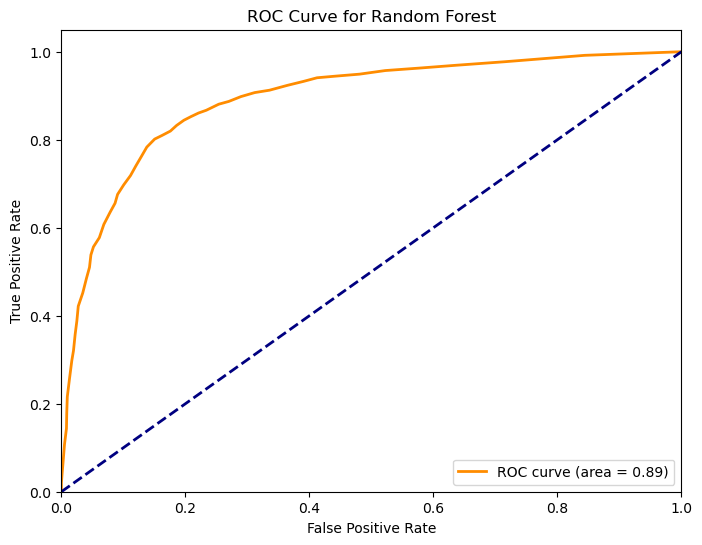

In [142]:
train_df = train_df.fillna(0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
y = y[y.index.isin(train_df.index)]
y_1 = y[['state_m','state_m+1']].replace({'Active':0, 'Active_1N':1 , 'Active_2N':1})
y_1['label'] = y_1['state_m']| y_1['state_m+1']
y_1 = y_1['label']
trainer = Training_module(X, y_1)
trainer.train_random_forest()

In [165]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23","06'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-07']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2022-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [166]:
val_df = val_df.fillna(0)
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_1 = sc.fit_transform(val_df)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_1)
pred_proba = loaded_model.predict_proba(val_df_1)[:,1]
val_df['predicted'] = predictions
val_df['predict_proba'] = pred_proba

In [167]:
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
pivot_2.loc[pivot_2['2023-09'] > 0, 'actual'] = 0
pivot_2.loc[pivot_2['2023-09'] <= 0, 'actual'] = 1

In [168]:
sep_result = result_matrix[['2023-08']].merge(pivot_2['actual'], left_index=True , right_index=True)

In [169]:
sep_result = sep_result[sep_result.index.isin(val_df.index)]

In [183]:
sep_result['2023-08'] =sep_result['2023-08'].replace({'Active':0,'Active_1N':1 , 'Active_2N':1}) 
sep_result['actual'] = sep_result['actual'].astype('int')

In [184]:
sep_result['label'] = sep_result['2023-08']|sep_result['actual']

In [186]:
val_df = val_df.merge(sep_result['label'], left_index=True , right_index=True)

In [192]:
print(confusion_matrix(val_df['label'], val_df['predicted']))
print(classification_report(val_df['label'], val_df['predicted']))

[[4594 1497]
 [ 234  586]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      6091
           1       0.28      0.71      0.40       820

    accuracy                           0.75      6911
   macro avg       0.62      0.73      0.62      6911
weighted avg       0.87      0.75      0.79      6911



In [196]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["04'23","05'23"])]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_jul = result_matrix[result_matrix['2023-07']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_jul = pivot[pivot.index.isin(result_jul.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_jul = pivot_jul[['2021-07','2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_jul_1 = result_jul[['2022-07','2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_jul.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_jul_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_jul = instance_2.data(pivot_jul, result_jul_1)
val_df_jul = instance_2.discount_pd(val_df_jul , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_jul = instance_2.district(val_df_jul , distt_df , region_df)

In [200]:
val_df_jul= val_df_jul.fillna(0)

In [201]:
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_jul_1 = sc.fit_transform(val_df_jul)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_jul_1)
pred_proba = loaded_model.predict_proba(val_df_jul_1)[:,1]
val_df_jul['predicted'] = predictions
val_df_jul['predict_proba'] = pred_proba
val_df_jul['label'] = 1

In [203]:
val_jul_aug = pd.concat([val_df, val_df_jul], axis = 0)

In [206]:
print(confusion_matrix(val_jul_aug['label'], val_jul_aug['predicted']))
print(classification_report(val_jul_aug['label'], val_jul_aug['predicted']))

[[4594 1497]
 [ 488  799]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6091
           1       0.35      0.62      0.45      1287

    accuracy                           0.73      7378
   macro avg       0.63      0.69      0.63      7378
weighted avg       0.81      0.73      0.76      7378



In [213]:
result = result_matrix[['2023-06','2023-07','2023-08']].merge(pivot_2['actual'], left_index=True , right_index=True)

In [215]:
result = result[result['2023-06'].isin(['Active_1N','Active_2N'])]

In [221]:
result = result[result.index.isin(val_jul_aug.index)==False]

In [223]:
result = result.replace({'Active':0 , 'Active_1N':1 , 'Active_2N':1, 'Active_3N':1, 'Inactive':1})
result['label'] = result['2023-07']|result['2023-08']
result['predicted'] = 1

In [226]:
result = result[['label','predicted']]
result_1 = val_jul_aug[['label','predicted']]

In [227]:
result = pd.concat([result , result_1], axis = 0)

In [228]:
print(confusion_matrix(result['label'], result['predicted']))
print(classification_report(result['label'], result['predicted']))

[[4594 1497]
 [ 488 1268]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6091
           1       0.46      0.72      0.56      1756

    accuracy                           0.75      7847
   macro avg       0.68      0.74      0.69      7847
weighted avg       0.80      0.75      0.76      7847



In [108]:
pivot_5 = pivot.merge(distt_df['sold_to_party_district_name'], left_index=True , right_index = True , how = 'inner')
pivot_5['1st_6m'] = pivot_5[['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09']].sum(axis =1)
pivot_5['2nd_6m'] = pivot_5[['2022-10','2022-11','2022-12','2023-01','2023-02','2023-03']].sum(axis =1)
distt_groupby = pivot_5.groupby('sold_to_party_district_name').agg({'1st_6m':['sum'],'2nd_6m':['sum']})
distt_groupby.columns = ['1st_6m','2nd_6m']
distt_groupby['distt_growth'] = (distt_groupby['2nd_6m']-distt_groupby['1st_6m'])/distt_groupby['1st_6m']
distt_groupby = distt_groupby.fillna(0)
pivot_5['growth_dealer'] = (pivot_5['2nd_6m']-pivot_5['1st_6m'])/pivot_5['1st_6m']
pivot_5 = pivot_5.fillna(0)
pivot_5 = pivot_5.replace({np.inf:0})
train_df_1 = train_df.drop(['sold_to_party_district_name', 'sales_region'], axis = 1)
train_df_1.index = train_df.index
train_df_1 = train_df_1.merge(distt_df['sold_to_party_district_name'], left_index=True, 
                             right_index=True , how = 'inner').merge(region_df['sales_region'], left_index=True , right_index=True, 
                                                                    how = 'inner')
distt_groupby['sold_to_party_district_name'] = distt_groupby.index
train_df_1 = train_df_1.merge(distt_groupby['distt_growth'], left_on='sold_to_party_district_name' , right_on='sold_to_party_district_name', how = 'inner')
train_df_1.index = train_df.index
train_df_1 = train_df_1.merge(pivot_5['growth_dealer'], left_index = True , right_index=True , how = 'inner')

NameError: name 'distt_groupby' is not defined

In [109]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df_1['sold_to_party_district_name'] = le.fit_transform(train_df_1['sold_to_party_district_name'])
train_df_1['sales_region'] = le.fit_transform(train_df_1['sales_region'])

In [110]:
train_df_1.replace([np.inf, -np.inf], 0, inplace=True)

In [111]:
# train_df_1['dealer_v_distt'] = train_df_1['growth_dealer']/train_df_1['distt_growth']
# train_df_1.drop(['dealer_v_distt','growth_dealer'], axis = 1 , inplace = True)

In [112]:
X = sc.fit_transform(train_df_1)
y_1 = y['state_m'].replace({'Active':0 , 'Active_1N':1})

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2330
           1       0.87      0.60      0.71       975

    accuracy                           0.86      3305
   macro avg       0.86      0.78      0.81      3305
weighted avg       0.86      0.86      0.85      3305

Confusion Matrix for Random Forest:

[[2242   88]
 [ 386  589]]


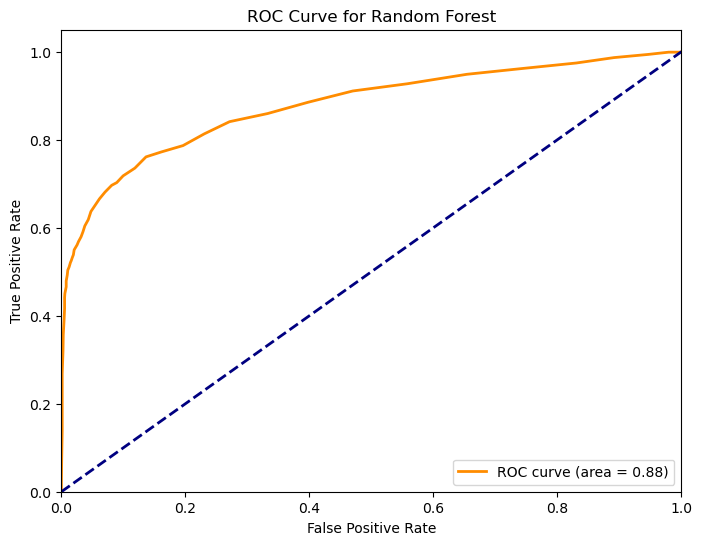

In [113]:
trainer = Training_module(X, y_1)
trainer.train_random_forest()

### Aug-Sep

In [114]:
pivot, result_matrix = instance.state_matrix(16)

In [115]:
pivot_6 = pivot.merge(distt_df['sold_to_party_district_name'], left_index=True , right_index = True , how = 'inner')
pivot_6['1st_6m'] = pivot_6[['2022-09','2022-10','2022-11','2022-12','2023-01','2023-02']].sum(axis =1)
pivot_6['2nd_6m'] = pivot_6[['2023-03','2023-04','2023-05','2023-06','2023-07','2023-08']].sum(axis =1)
distt_groupby = pivot_6.groupby('sold_to_party_district_name').agg({'1st_6m':['sum'],'2nd_6m':['sum']})
distt_groupby.columns = ['1st_6m','2nd_6m']
distt_groupby['distt_growth'] = (distt_groupby['2nd_6m']-distt_groupby['1st_6m'])/distt_groupby['1st_6m']
distt_groupby = distt_groupby.fillna(0)
pivot_6['growth_dealer'] = (pivot_6['2nd_6m']-pivot_6['1st_6m'])/pivot_6['1st_6m']
pivot_6 = pivot_6.fillna(0)
pivot_6 = pivot_6.replace({np.inf:0})


In [116]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2022-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)
result_aug = result_matrix[result_matrix['2023-08']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_aug = pivot[pivot.index.isin(result_aug.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_aug = pivot_aug[['2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_aug_1 = result_aug[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_aug.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_aug_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_aug= instance_2.data(pivot_aug, result_aug_1)
val_df_aug = instance_2.discount_pd(val_df_aug ,  discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_aug = instance_2.district(val_df_aug , distt_df , region_df)
val_df_aug['actual']=1

In [117]:
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
pivot_2.loc[pivot_2['2023-09'] > 0, 'actual'] = 0
pivot_2.loc[pivot_2['2023-09'] <= 0, 'actual'] = 1
val_df = val_df.merge(pivot_2['actual'], left_index=True , right_index = True , how = 'inner')

In [118]:
val_df_sep_aug = pd.concat([val_df, val_df_aug], axis = 0)
val_df_sep_aug = val_df_sep_aug.fillna(0)

In [119]:
val_df_sep_aug.drop(['sold_to_party_district_name', 'sales_region'], axis = 1 , inplace = True)

In [120]:
#val_df_sep_aug.index =val_df_sep_aug.index
val_df_sep_aug_1 = val_df_sep_aug.merge(distt_df['sold_to_party_district_name'], left_index=True, 
                             right_index=True , how = 'inner').merge(region_df['sales_region'], left_index=True , right_index=True, 
                                                                    how = 'inner')
distt_groupby['sold_to_party_district_name'] = distt_groupby.index
val_df_sep_aug_1 = val_df_sep_aug_1.merge(distt_groupby['distt_growth'], left_on='sold_to_party_district_name' , right_on='sold_to_party_district_name', how = 'inner')
val_df_sep_aug_1.index = val_df_sep_aug.index
val_df_sep_aug_1 = val_df_sep_aug_1.merge(pivot_6['growth_dealer'], left_index = True , right_index=True , how = 'inner')

In [121]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
val_df_sep_aug_1['sold_to_party_district_name'] = le.fit_transform(val_df_sep_aug_1['sold_to_party_district_name'])
val_df_sep_aug_1['sales_region'] = le.fit_transform(val_df_sep_aug_1['sales_region'])
val_df_sep_aug_1.replace([np.inf, -np.inf], 0, inplace=True)
X_val = sc.fit_transform(val_df_sep_aug_1.drop('actual', axis = 1))
y_val = val_df_sep_aug_1['actual']

In [122]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
#val_df_1 = sc.fit_transform(val_df)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_val)
pred_proba = loaded_model.predict_proba(X_val)[:,1]
val_df_sep_aug['predicted'] = predictions
val_df_sep_aug['predict_proba'] = pred_proba

In [100]:
val_df_sep_aug_1

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,actual,sold_to_party_district_name,sales_region,distt_growth,growth_dealer
7000004,80.00,96.0,111.00,58.00,61.00,-3.0,5.00,-26.5,91.00,34.00,...,0.0,0.0,0.0,26859.696000,9972.625,0.0,25,1,0.182022,0.634532
7000010,106.00,192.0,107.00,35.00,-97.00,-112.0,50.00,-101.0,4.00,55.50,...,0.0,0.0,0.0,45710.852000,12714.815,0.0,25,1,0.182022,0.000000
7000022,183.00,187.0,267.00,36.00,-50.00,50.0,-20.00,47.5,132.00,-73.00,...,0.0,0.0,0.0,87583.118438,27527.270,0.0,25,1,0.182022,0.083333
7000025,426.25,561.5,679.25,55.75,-51.75,286.5,-295.25,-124.5,350.25,-135.25,...,0.0,0.0,0.0,224966.699875,68955.480,0.0,25,1,0.182022,0.335878
7000029,40.00,30.0,51.00,28.00,0.00,39.0,16.00,-2.0,29.00,-11.00,...,0.0,0.0,0.0,10005.403438,4806.585,0.0,25,1,0.182022,0.087420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036876,32.00,0.0,52.00,32.00,0.00,52.0,32.00,-83.0,21.00,-30.00,...,0.0,0.0,0.0,12013.333333,10400.000,1.0,140,5,0.004831,-0.181521
7036901,50.00,50.0,50.00,50.00,50.00,50.0,0.00,-70.0,-96.00,-35.00,...,0.0,0.0,0.0,43871.990000,13671.875,0.0,112,4,-0.571248,0.000000
7036934,100.00,50.0,25.00,50.00,25.00,-60.0,-15.00,-55.0,-35.00,100.00,...,1.0,0.0,0.0,34040.540000,10285.125,1.0,322,3,-0.663462,-0.200000
7036958,17.00,0.0,50.00,0.00,-110.00,31.0,-127.00,-141.0,20.00,-183.00,...,0.0,0.0,0.0,36749.101250,0.000,1.0,312,3,-0.287675,-0.484553


In [123]:
print('CONFUSION MATRIX SEPTEMBER')
print(confusion_matrix(val_df_sep_aug['actual'],val_df_sep_aug['predicted']))
print('\n')
print('CLASSIFICATION REPORT SEPTEMBER')
print(classification_report(val_df_sep_aug['actual'],val_df_sep_aug['predicted']))

CONFUSION MATRIX SEPTEMBER
[[6613   33]
 [1022    9]]


CLASSIFICATION REPORT SEPTEMBER
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      6646
         1.0       0.21      0.01      0.02      1031

    accuracy                           0.86      7677
   macro avg       0.54      0.50      0.47      7677
weighted avg       0.78      0.86      0.80      7677



In [32]:
instance = DB_Data(host, database, user, password, sql_query)
pivot_jul, result_matrix_jul = instance.state_matrix(15)

In [33]:
predicted_churn = pd.read_excel('Predicted_Churn.xlsx')

In [34]:
predicted_churn = predicted_churn[predicted_churn['creationTime']=='2023-07-01']

In [35]:
predicted_churn

,dealerId,creationTime
2923,7006335,2023-07-01
2924,7031807,2023-07-01
2925,7037790,2023-07-01
2926,7040120,2023-07-01
2927,7007754,2023-07-01
...,...,...
3770,7040115,2023-07-01
3771,7005881,2023-07-01
3772,7031798,2023-07-01
3773,7037788,2023-07-01


In [36]:
result_matrix_jul = result_matrix_jul[result_matrix_jul.index.isin(predicted_churn['dealerId'])]

In [37]:
result_matrix_jul

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000059,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000218,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active_1N,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000318,Active,Active_1N,Active,Active_1N,Active,Active_1N,Active,Active_1N,Active_2N,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,Active,Active_1N,Active_2N,Active_3N,Inactive
7000460,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active,Active,...,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000654,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036804,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7036807,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active_1N,Active,Active,Active,Active_1N,Active,Active
7036878,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active,Active_1N,Active,Active_1N,Active_2N,Active_3N,Inactive


In [38]:
result_matrix_jul.to_excel('result_matrix_jul.xlsx')

In [39]:
result_matrix_jul['2023-06'].value_counts()

Active_2N    258
Active_1N    148
Active         4
Name: 2023-06, dtype: int64

In [40]:
result_matrix_jul['2023-07'].value_counts()

Active_3N    207
Active       117
Active_2N     84
Active_1N      2
Name: 2023-07, dtype: int64

In [41]:
result_matrix_jul['2023-08'].value_counts()

Inactive     191
Active       119
Active_3N     65
Active_1N     34
Active_2N      1
Name: 2023-08, dtype: int64

In [15]:
result_matrix_jul = result_matrix_jul[['2023-07','2023-08']].replace({'Active_3N':1,'Inactive':1, 'Active':0,'Active_1N':0, 'Active_2N':0})

In [17]:
result_matrix_jul['actual'] = result_matrix_jul['2023-07']|result_matrix_jul['2023-08']

In [19]:
result_matrix_jul['predicted']=1

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(result_matrix_jul['2023-08'], result_matrix_jul['predicted']))
print(classification_report(result_matrix_jul['2023-08'], result_matrix_jul['predicted']))
print(accuracy_score(result_matrix_jul['2023-08'],result_matrix_jul['predicted'] ))

[[  0 154]
 [  0 256]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.62      1.00      0.77       256

    accuracy                           0.62       410
   macro avg       0.31      0.50      0.38       410
weighted avg       0.39      0.62      0.48       410

0.624390243902439


In [42]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self, month_new):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=month_new]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'`
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self , month_new):
        df, result_matrix = self.create_result_matrix(month_new)
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        #df.drop('month_new_dealer', axis = 1 , inplace = True)
        result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix

In [43]:
instance = DB_Data(host, database, user, password, sql_query)
pivot, result_matrix = instance.state_matrix(28)

In [46]:
pivot.to_excel('sales_pivot_master.xlsx')

In [79]:
pivot_a = pivot[pivot['month_new_dealer']<=16]
pivot_a = pivot_a[pivot_a.index.isin(predicted_churn['dealerId'])]

In [80]:
result_matrix_a = result_matrix[result_matrix.index.isin(pivot_a.index)]

In [81]:
result_matrix_a['2023-06'].value_counts()

Active_2N    263
Active_1N    157
Active         4
Name: 2023-06, dtype: int64

In [84]:
result_matrix[result_matrix.index.isin(predicted_churn['dealerId'])]['2023-06'].value_counts()

Active_1N    431
Active_2N    406
Active        15
Name: 2023-06, dtype: int64

In [85]:
result_matrix[result_matrix.index.isin(predicted_churn['dealerId'])]['2023-07'].value_counts()

Active_3N    332
Active       263
Active_2N    250
Active_1N      7
Name: 2023-07, dtype: int64

In [88]:
result_matrix['2023-07'].value_counts()

Active       9992
Churn        2578
Inactive     2040
Active_1N     914
Active_2N     457
Active_3N     367
-             333
Name: 2023-07, dtype: int64

In [89]:
result_matrix_a['2023-07'].value_counts()

Active_3N    212
Active       121
Active_2N     89
Active_1N      2
Name: 2023-07, dtype: int64

In [93]:
pivot_b= pivot[pivot['month_new_dealer']<=16]
result_matrix[result_matrix.index.isin(pivot_b.index)]['2023-07'].value_counts()

Active       7274
Churn        2578
Inactive     1671
Active_1N     502
Active_2N     271
Active_3N     245
Name: 2023-07, dtype: int64

In [69]:
result_matrix_a = result_matrix_a[['2023-07','2023-08']]
result_matrix_a[(result_matrix_a['2023-07']=='Active_3N')|(result_matrix_a['2023-08']=='Active_3N')]

Month Year,2023-07,2023-08
Sold To Party Code,,
7000059,Active_3N,Inactive
7000218,Active_3N,Inactive
7000318,Active_3N,Inactive
7000460,Active_3N,Inactive
7000654,Active_3N,Active
...,...,...
7037003,Active_3N,Inactive
7037009,Active_3N,Inactive
7037047,Active_3N,Inactive


In [73]:
result_matrix[(result_matrix['2023-07']=='Active_3N')|(result_matrix['2023-08']=='Active_3N')]

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000059,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000218,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active_1N,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000318,Active,Active_1N,Active,Active_1N,Active,Active_1N,Active,Active_1N,Active_2N,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,Active,Active_1N,Active_2N,Active_3N,Inactive
7000460,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active,Active,...,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive
7000654,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040539,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active_1N,Active_2N,Active_3N
7040568,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active_1N,Active_2N,Active_3N
7040605,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active_1N,Active_2N,Active_3N


In [74]:
 pivot_b = pivot[pivot.index.isin(predicted_churn['dealerId'])]

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000059,30.0,85.0,30.00,15.0,60.0,32.5,77.5,52.0,27.5,70.0,...,45.10,52.5,27.5,20.0,12.0,0.0,0.0,0.0,0.0,0
7000218,10.0,12.0,24.00,0.0,24.0,12.0,0.0,22.0,0.0,10.0,...,24.00,12.0,5.0,12.0,12.0,0.0,0.0,0.0,0.0,0
7000318,30.0,0.0,29.00,0.0,30.0,0.0,25.0,0.0,0.0,25.0,...,0.00,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0
7000460,33.0,12.0,15.00,10.0,15.0,10.0,0.0,15.0,17.5,15.0,...,10.05,14.9,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0
7000654,270.5,205.9,234.95,219.0,359.4,276.0,325.7,258.0,318.5,290.0,...,372.00,144.5,326.0,568.0,97.0,0.0,0.0,0.0,178.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040640,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,25
7040682,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,10.0,0.0,5.0,0.0,25
7040710,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,26


In [ ]:
result_matrix[(result_matrix['2023-07']=='Active_3N')|(result_matrix['2023-08']=='Active_3N')]

In [592]:
result_matrix_3[result_matrix_3['2023-10'].isin(['Active','Active_1N', 'Active_2N' , 'Active_3N'])].to_excel('l12m_active.xlsx')

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active,Active,Active
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000029,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042341,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042347,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042369,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042371,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active


In [594]:
result_matrix_3[result_matrix_3['2023-07'].isin(['Active','Active_1N', 'Active_2N' , 'Active_3N'])].to_excel('l12m_jul.xlsx')

In [600]:
result_matrix_3[result_matrix_3['2023-10'].isin(['Active','Active_1N', 'Active_2N' , 'Active_3N'])]

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active,Active,Active
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000029,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042341,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042347,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042369,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active
7042371,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Active


In [601]:
result_matrix_3[result_matrix_3['2023-07'].isin(['Active','Active_1N', 'Active_2N' , 'Active_3N'])]

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active,Active,Active
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000029,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041475,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active,Active,Active
7041477,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active,Active,Active
7041478,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active,Active,Active
7041494,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,Active,Active,Active,Active


,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.0,66.0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.0,12.0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
7042137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
7042142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
7042147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


In [606]:
instance = DB_Data(host, database, user, password, sql_query)
pivot_5, result_matrix_5 = instance.state_matrix(31)

TypeError: DB_Data.state_matrix() missing 1 required positional argument: 'df'

In [626]:
result_matrix_3

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,month_new_dealer
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,31
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Active,Active,Active,Active,Active,Active,31
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,31
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,31
7000022,-,-,-,-,-,-,-,-,-,-,...,Active_1N,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042341,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,1
7042347,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,1
7042369,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,1
7042371,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,1


In [628]:
pivot_4.to_excel('updated_pivot.xlsx')